# Test hybrid model

Test a hybrid neural network model which includes hourly and 1-minute data in the same model

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from model_definitions import (define_model_cnn_1_min, define_model_cnn_hourly, define_model_lstm_1_min, define_model_lstm_hourly, 
                               define_model_cnn_lstm_1_min, define_model_cnn_lstm_hourly, define_model_cnn_hybrid)
from preprocessing import combine_old_and_new_data
from predict import load_models, predict_batch
from train import train_nn_models, train_nn_hybrid_models
import time
from typing import Callable, Tuple
import tensorflow as tf
from plotting import plot_binned_RMSE
import matplotlib.pyplot as plt


In [2]:
# download and save data
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
# !unzip public.zip
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
# !unzip private.zip
# !mkdir data
# !mv public data
# !mv private data

In [3]:
# user options
retrain_models = True # if true, train and save models, otherwise load pre-trained models from disk
model = "hybrid_cnn"

In [4]:
# load recent data
data_folder = "data"
solar_train = pd.read_csv(os.path.join(data_folder, "public", "solar_wind.csv"))
dst_train = pd.read_csv(os.path.join(data_folder, "public", "dst_labels.csv"))
sunspots_train = pd.read_csv(os.path.join(data_folder, "public", "sunspots.csv"))
solar_test = pd.read_csv(os.path.join(data_folder, "private", "solar_wind.csv"))
dst_test = pd.read_csv(os.path.join(data_folder, "private", "dst_labels.csv"))
sunspots_test = pd.read_csv(os.path.join(data_folder, "private", "sunspots.csv"))

In [5]:
# Load older data
solar_old = pd.read_csv(os.path.join(data_folder, "old", "solar_wind.csv"))
dst_old = pd.read_csv(os.path.join(data_folder, "old", "dst_labels.csv"))
sunspots_old = pd.read_csv(os.path.join(data_folder, "old", "sunspots.csv"))
# Merge data - train on old and recent public data, test on recent private data
solar_train_hourly = combine_old_and_new_data(solar_old, solar_train)
sunspots_train_hourly = pd.concat([sunspots_train, sunspots_old], axis=0)
dst_train_hourly = pd.concat([dst_train, dst_old], axis=0)
solar_test_hourly = solar_test.copy()
# Extract hourly data
solar_test_hourly = combine_old_and_new_data(pd.DataFrame(), solar_test)

In [6]:
# train hybrid model
output_folder = os.path.join("trained_models", model, "benchmark")
output_folder_hourly = os.path.join("trained_models", model, "hourly_part", "benchmark")
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_folder_hourly, exist_ok=True)
if retrain_models:
    train_nn_hybrid_models(
            solar_train_hourly,
            solar_train,
            sunspots_train_hourly,
            dst_train_hourly,
            define_model_cnn_hybrid,
            1,
            output_folder,
            output_folder_hourly,
            early_stopping=False,
    )

4350/4350 [==============================] - 19s 4ms/step - loss: 151.9117 - root_mean_squared_error: 12.2342


In [25]:
# measure performance
output_folder = os.path.join("trained_models", model, "benchmark")
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)

dst_test['timedelta'] = pd.to_timedelta(dst_test['timedelta'])
# exclude times in the first week + 1 hour of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7, hours=1)].copy()
predictions = predict_batch(
    solar_test, sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, "hybrid"
)
dst_test = pd.merge(dst_test[['period', 'timedelta', 'dst']], predictions, "left", ["period", "timedelta"])
dst_test.sort_values(["period", "timedelta"], inplace=True)
dst_test["dst_t_plus_1"] = dst_test.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test["dst"].values, dst_test["prediction_t"].values)
)
valid_ind = dst_test["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")

RMSE for time t: 13.86
RMSE for time t+1: 13.70


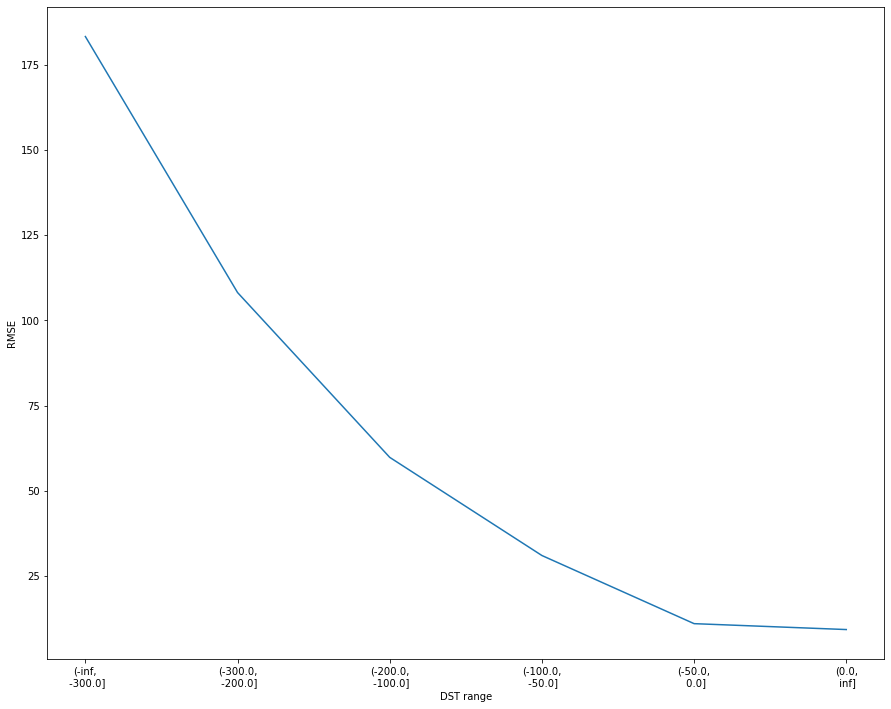

In [27]:
# plot errors in different DST ranges
plt.figure(figsize=(15, 12))
bins = [-np.inf, -300, -200, -100, -50, 0, np.inf]
plot_binned_RMSE(dst_test.loc[valid_ind, "dst"].values, dst_test.loc[valid_ind, "prediction_t"].values, bins)


In [28]:
# size of ranges
bin_id = pd.cut(dst_test.loc[valid_ind, "dst"], bins).to_frame("bin")
bin_id.groupby("bin").size().to_frame("size")

,size
bin,
"(-inf, -300.0]",17
"(-300.0, -200.0]",33
"(-200.0, -100.0]",436
"(-100.0, -50.0]",2516
"(-50.0, 0.0]",43218
"(0.0, inf]",12454


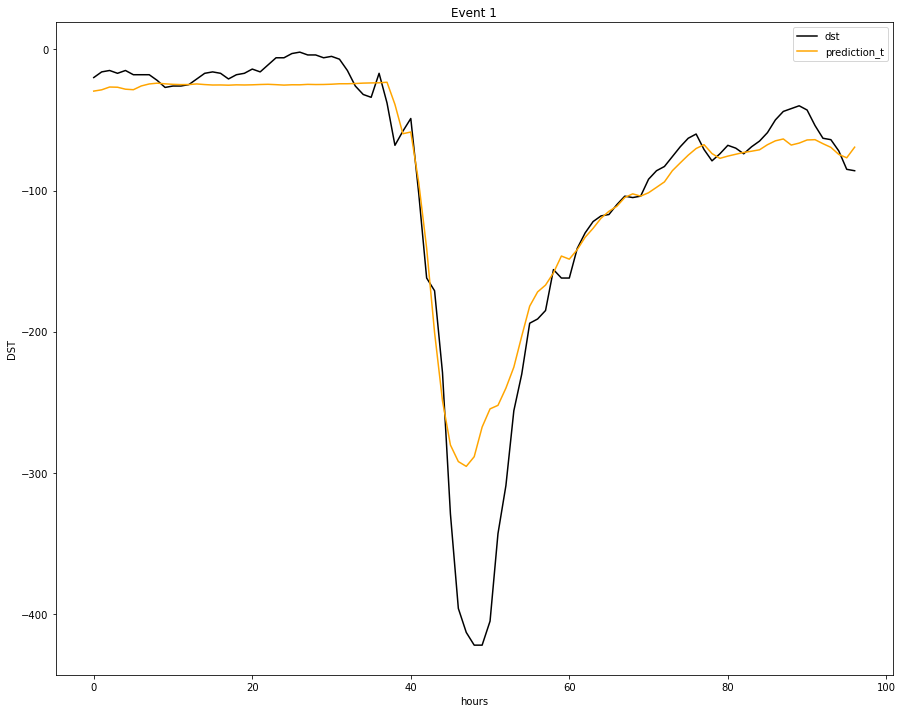

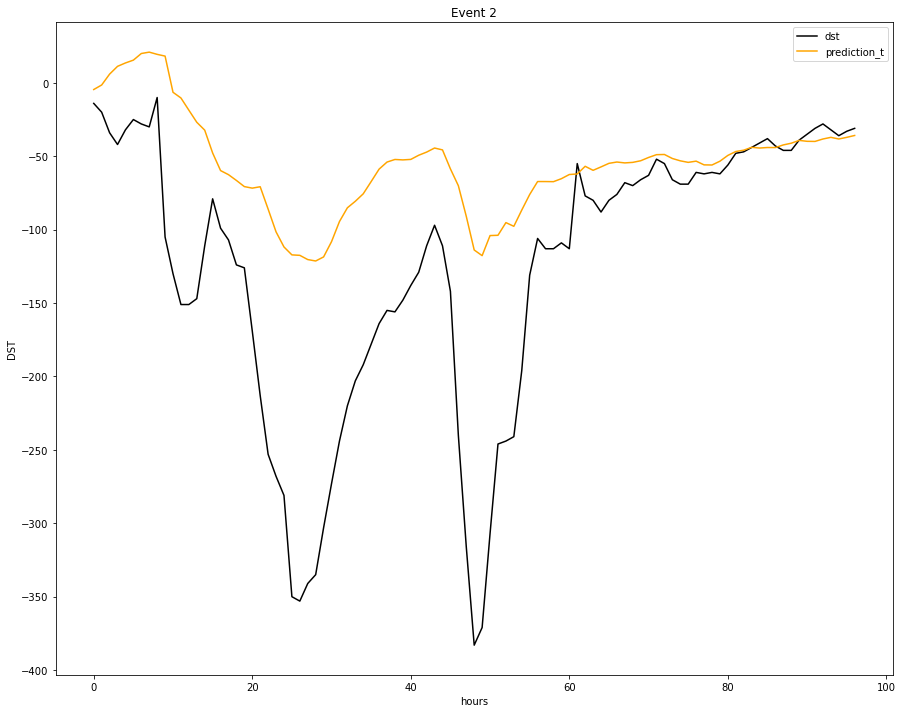

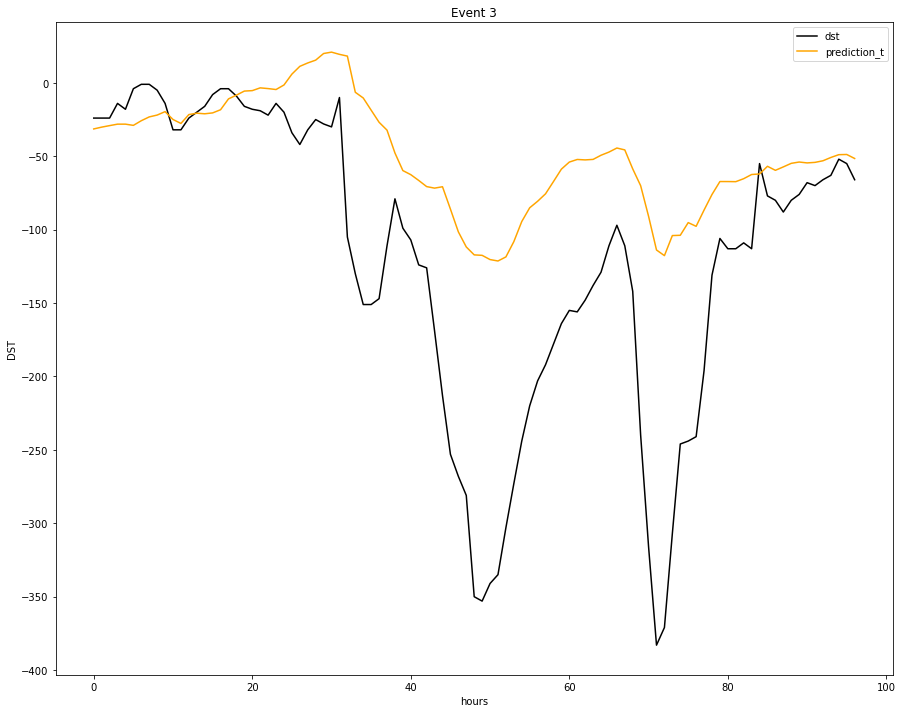

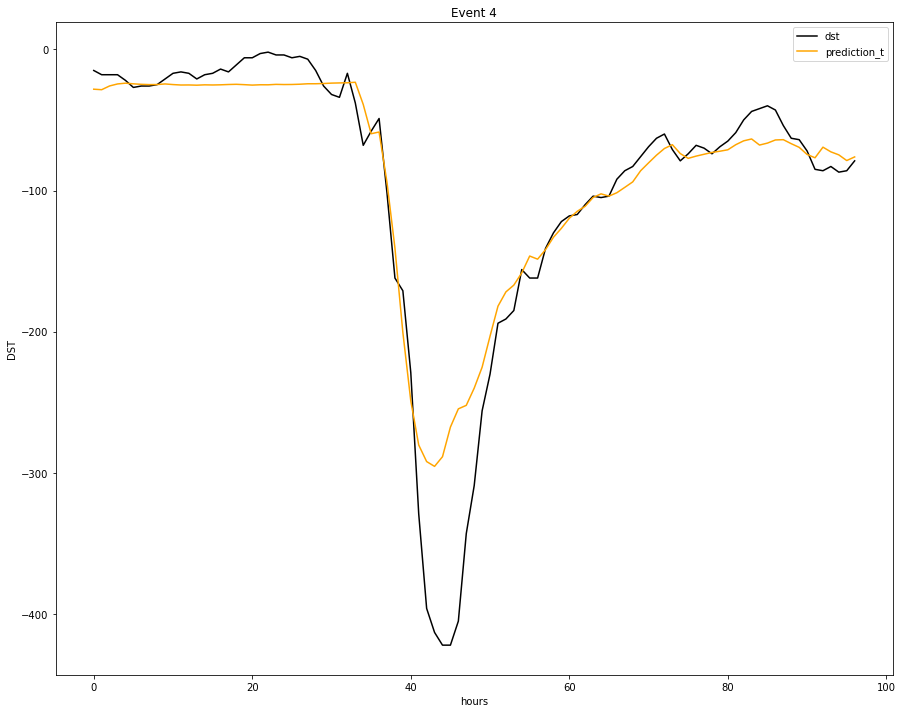

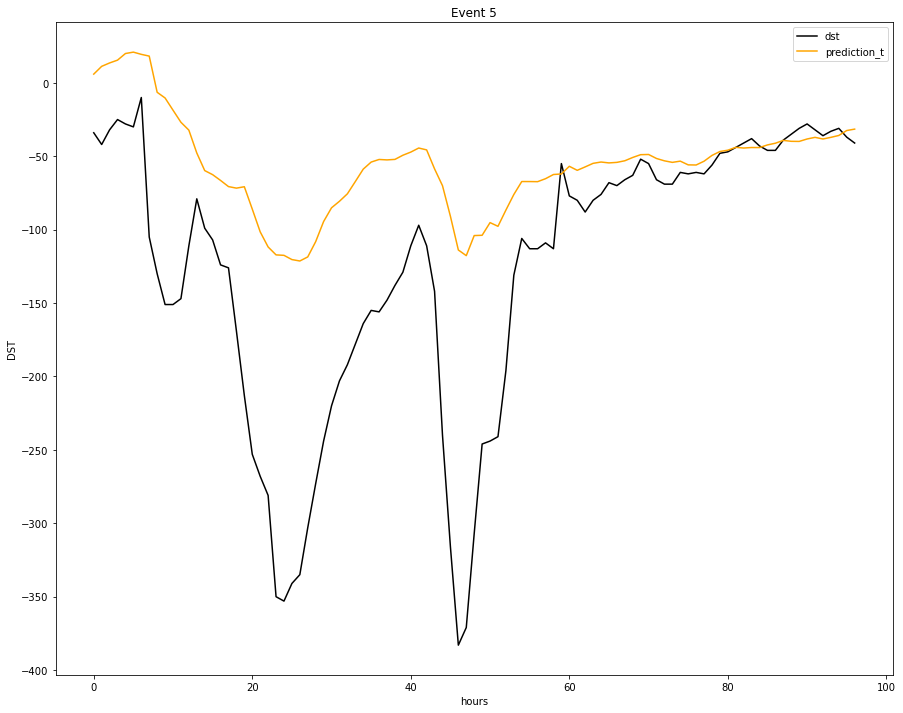

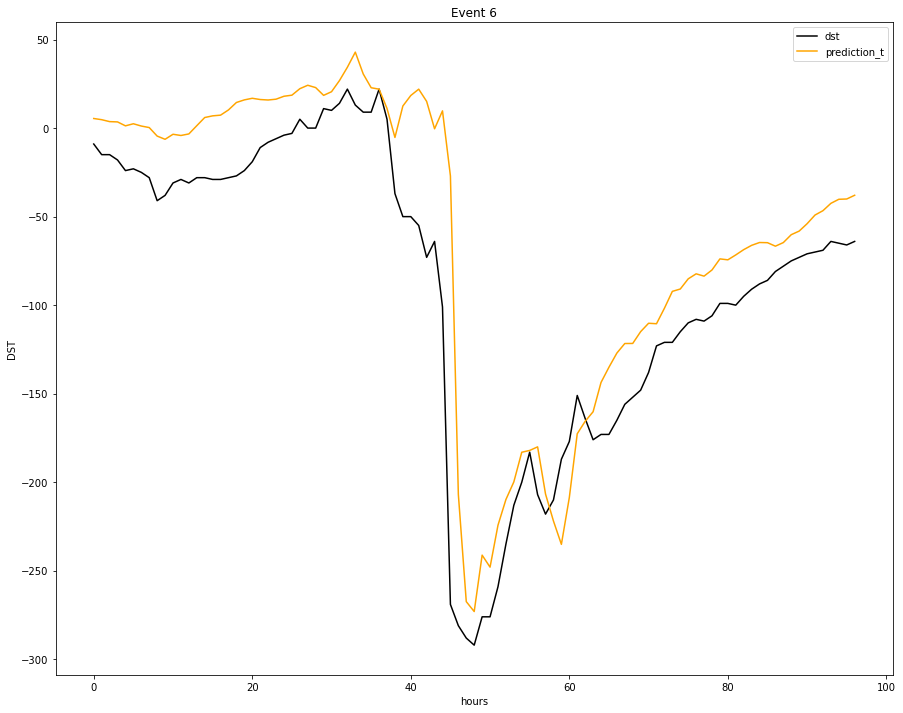

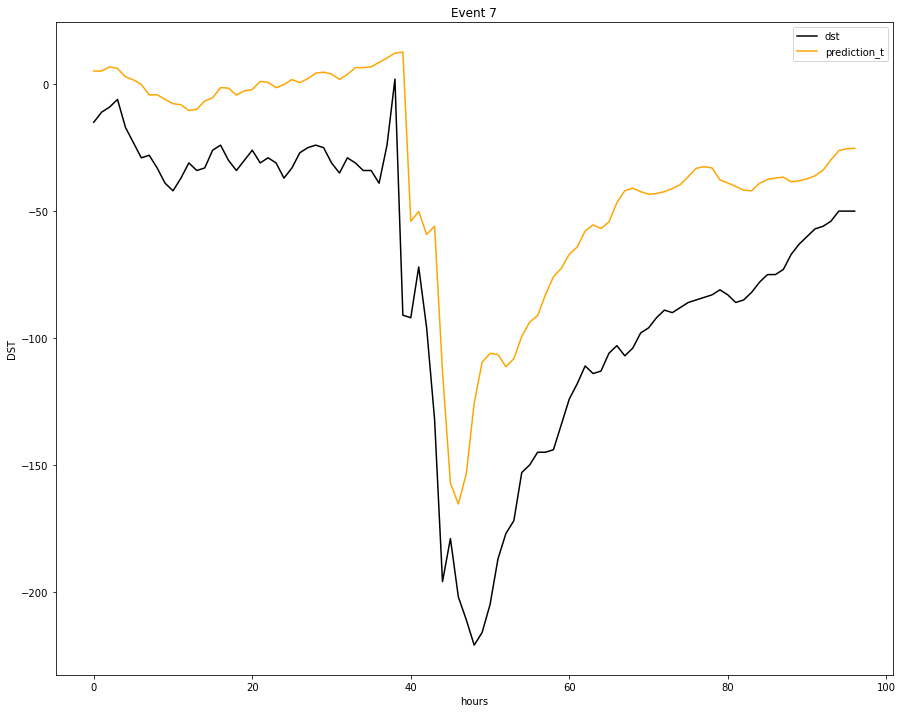

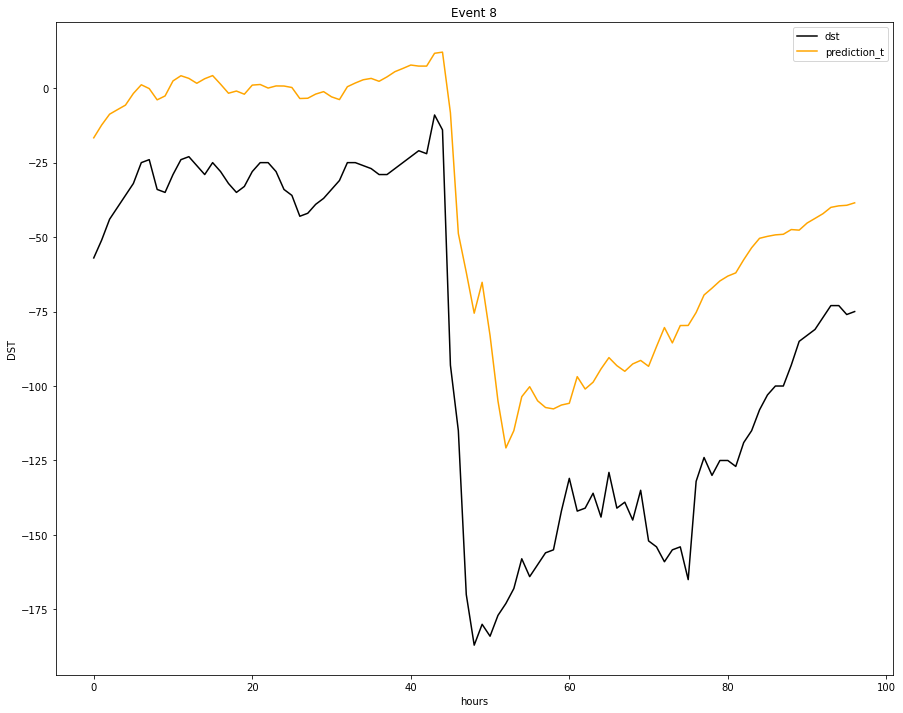

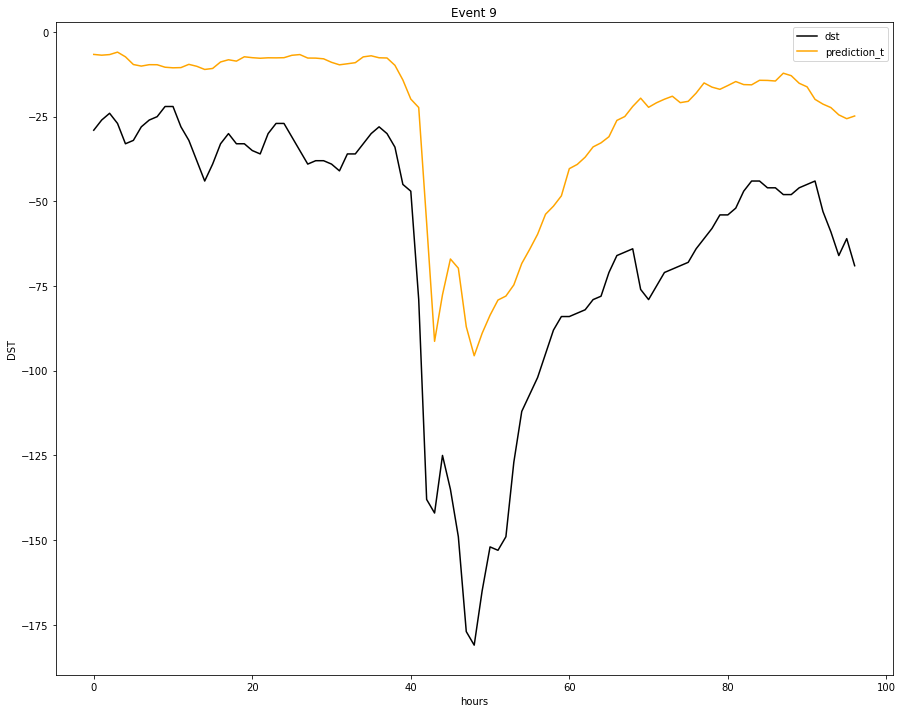

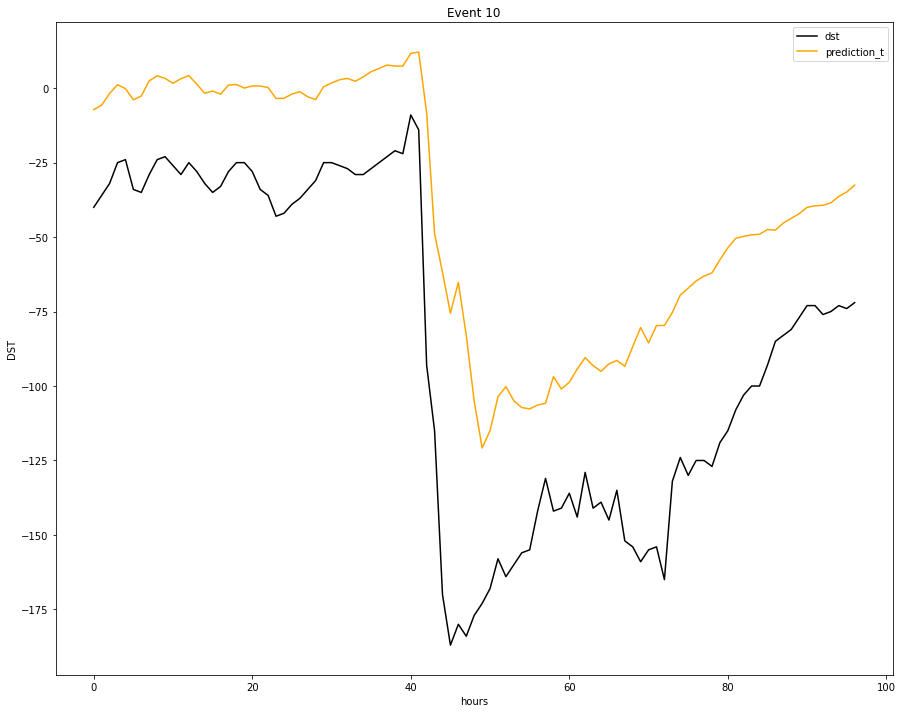

In [31]:
# plot forecast vs actual at storm events
num_events = 10
# calculate max by day, and select top n days
dst_test["day"] = dst_test["timedelta"].dt.days
dst_day_min = dst_test.groupby(["period", "day"])["dst"].min().to_frame("min_dst")
dst_day_min["min_idx"] = dst_test.groupby(["period", "day"])["dst"].idxmin()

top_n = dst_day_min.nsmallest(num_events, columns="min_dst").sort_values("min_dst")
for i in range(num_events):
    # extract 48 hours before and after max
    ind = top_n["min_idx"].iloc[i]
    df = dst_test.loc[ind - 48: ind + 48].copy()
    plt.figure(figsize=(15, 12))
    plt.plot(df["dst"].values, c="black")
    plt.plot(df["prediction_t"].values, c="orange")
    plt.legend(["dst", "prediction_t"])
    plt.title(f"Event {i + 1}")
    plt.xlabel("hours")
    plt.ylabel("DST")


In [30]:
df

,period,timedelta,dst,prediction_t_x,prediction_t_plus_1,dst_t_plus_1,day,prediction_t_y
0,test_a,900 days 20:00:00,-20,-29.606018,-27.775198,-16.0,900,-29.606018
1,test_a,900 days 21:00:00,-16,-28.693062,-27.479414,-15.0,900,-28.693062
2,test_a,900 days 22:00:00,-15,-26.711361,-24.904255,-17.0,900,-26.711361
3,test_a,900 days 23:00:00,-17,-26.858158,-25.748095,-15.0,900,-26.858158
4,test_a,901 days 00:00:00,-15,-28.254267,-26.660099,-18.0,901,-28.254267
...,...,...,...,...,...,...,...,...
92,test_a,904 days 16:00:00,-63,-66.843987,-71.803741,-64.0,904,-66.843987
93,test_a,904 days 17:00:00,-64,-69.431473,-73.464233,-72.0,904,-69.431473
94,test_a,904 days 18:00:00,-72,-74.456711,-84.813866,-85.0,904,-74.456711
95,test_a,904 days 19:00:00,-85,-76.835106,-91.213173,-86.0,904,-76.835106
